# Assignment 2

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Keywords**: Transformers, Question Answering, CoQA

## Task and dataset explanation

### Overview

### Problem

Question Answering (QA) on [CoQA](https://stanfordnlp.github.io/coqa/) dataset: a conversational QA dataset.

### Task

Given a question $Q$, a text passage $P$, the task is to generate the answer $A$.<br>
$\rightarrow A$ can be: (i) a free-form text or (ii) unanswerable;

**Note**: an question $Q$ can refer to previous dialogue turns. <br>
$\rightarrow$ dialogue history $H$ may be a valuable input to provide the correct answer $A$.

### Models

We are going to experiment with transformer-based models to define the following models:

1.  $A = f_\theta(Q, P)$

2. $A = f_\theta(Q, P, H)$

where $f_\theta$ is the transformer-based model we have to define with $\theta$ parameters.

### The CoQA dataset

<center>
    <img src="https://drive.google.com/uc?export=view&id=16vrgyfoV42Z2AQX0QY7LHTfrgektEKKh" width="750"/>
</center>

For detailed information about the dataset, feel free to check the original [paper](https://arxiv.org/pdf/1808.07042.pdf).



### Rationales

Each QA pair is paired with a rationale $R$: it is a text span extracted from the given text passage $P$. <br>
$\rightarrow$ $R$ is not a requested output, but it can be used as an additional information at training time!

### Dataset Statistics

* **127k** QA pairs.
* **8k** conversations.
* **7** diverse domains: Children's Stories, Literature, Mid/High School Exams, News, Wikipedia, Reddit, Science.
* Average conversation length: **15 turns** (i.e., QA pairs).
* Almost **half** of CoQA questions refer back to **conversational history**.
* Only **train** and **validation** sets are available.

### Dataset snippet

The dataset is stored in JSON format. Each dialogue is represented as follows:

```
{
    "source": "mctest",
    "id": "3dr23u6we5exclen4th8uq9rb42tel",
    "filename": "mc160.test.41",
    "story": "Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton. 
    Cotton lived high up in a nice warm place above the barn where all of the farmer's horses slept. [...]" % <-- $P$
    "questions": [
        {
            "input_text": "What color was Cotton?",   % <-- $Q_1$
            "turn_id": 1
        },
        {
            "input_text": "Where did she live?",
            "turn_id": 2
        },
        [...]
    ],
    "answers": [
        {
            "span_start": 59,   % <-- $R_1$ start index
            "spand_end": 93,    % <-- $R_1$ end index
            "span_text": "a little white kitten named Cotton",   % <-- $R_1$
            "input_text" "white",   % <-- $A_1$      
            "turn_id": 1
        },
        [...]
    ]
}
```

### Simplifications

Each dialogue also contains an additional field ```additional_answers```. For simplicity, we **ignore** this field and only consider one groundtruth answer $A$ and text rationale $R$.

CoQA only contains 1.3% of unanswerable questions. For simplicity, we **ignore** those QA pairs.

## List of tasks

### [Task 1] Remove unaswerable QA pairs - DONE 

Write your own script to remove unaswerable QA pairs from both train and validation sets. The unanswarable questions have -1 both in 'span_start' and 'span_end' and *unknown* in 'span_text'.      
***WARNING***: I found out that the sample in position 8246 has 'unknown' as answer therefore we must use the 'span_start' attribute to check for answerability.

### [Task 2] Train, Validation and Test splits - DONE

CoQA only provides a train and validation set since the test set is hidden for evaluation purposes.

We'll consider the provided validation set as a test set. <br>
$\rightarrow$ Write your own script to:
* Split the train data in train and validation splits (80% train and 20% val)
* Perform splits such that a dialogue appears in one split only! (i.e., split at dialogue level)
* Perform splitting using the following seed for reproducibility: 42

#### Reproducibility Memo

Check back tutorial 2 on how to fix a specific random seed for reproducibility!

### [Task 3] Model definition

Write your own script to define the following transformer-based models from [huggingface](https://HuggingFace.co/).

* [M1] DistilRoBERTa (distilberta-base)
* [M2] BERTTiny (bert-tiny)

**Note**: Remember to install the ```transformers``` python package!

**Note**: We consider small transformer models for computational reasons!

### [Task 4] Question generation with text passage $P$ and question $Q$

We want to define $f_\theta(P, Q)$. 

Write your own script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$ and $Q_i$ and generate $A_i$.

### [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

We want to define $f_\theta(P, Q, H)$. Write your own script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$, $Q_i$, and $H = \{ Q_0, A_0, \dots, Q_{i-1}, A_{i-1} \}$ to generate $A_i$.

### [Task 6] Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

Write your own script to train and evaluate your $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$ models.

### Instructions

* Perform multiple train/evaluation seed runs: [42, 2022, 1337].$^1$
* Evaluate your models with the following metrics: SQUAD F1-score.$^2$
* Fine-tune each transformer-based models for **3 epochs**.
* Report evaluation SQUAD F1-score computed on the validation and test sets.

$^1$ Remember what we said about code reproducibility in Tutorial 2!

$^2$ You can use ```allennlp``` python package for a quick implementation of SQUAD F1-score: ```from allennlp_models.rc.tools import squad```. 

### [Task 7] Error Analysis

Perform a simple and short error analysis as follows:
* Group dialogues by ```source``` and report the worst 5 model errors for each source (w.r.t. SQUAD F1-score).
* Inspect observed results and try to provide some comments (e.g., do the models make errors when faced with a particular question type?)$^1$

$^1$ Check the [paper](https://arxiv.org/pdf/1808.07042.pdf) for some valuable information about question/answer types (e.g., Table 6, Table 8) 

## Dataset Download


In [1]:
import os
import os.path
import json
import typing
import urllib.request

import tensorflow.keras.callbacks
import tensorflow.keras.layers
import tensorflow.keras.losses
import tensorflow.keras.optimizers
import tensorflow.keras.regularizers
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm

In [2]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [3]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

coqa-train-v1.0.json: 49.0MB [00:08, 5.74MB/s]                            


Download completed!


coqa-dev-v1.0.json: 9.09MB [00:03, 2.85MB/s]                            

Download completed!


## Create the dataframe and inspect the data

In [180]:
train_path = './coqa/train.json'
test_path = './coqa/test.json'

with open(train_path, 'r') as f:
    train_json = json.load(f)

with open(test_path, 'r') as f:
    test_json = json.load(f)


In [181]:
df_train = pd.json_normalize(train_json['data'])
df_test = pd.json_normalize(test_json['data'])
df_train.head()

,source,id,filename,story,questions,answers,name
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",[{'input_text': 'When was the Vat formally ope...,"[{'span_start': 151, 'span_end': 179, 'span_te...",Vatican_Library.txt
1,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,cnn_fe05c61a7e48461f7883cdec387567029614f07b.s...,New York (CNN) -- More than 80 Michael Jackson...,"[{'input_text': 'Where was the Auction held?',...","[{'span_start': 243, 'span_end': 284, 'span_te...",cnn_fe05c61a7e48461f7883cdec387567029614f07b.s...
2,gutenberg,3bdcf01ogxu7zdn9vlrbf2rqzwplyf,data/gutenberg/txt/Zane Grey___Riders of the P...,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",[{'input_text': 'What did Venters call Lassite...,"[{'span_start': 841, 'span_end': 880, 'span_te...",data/gutenberg/txt/Zane Grey___Riders of the P...
3,cnn,3ewijtffvo7wwchw6rtyaf7mfwte0p,cnn_0c518067e0df811501e46b2e1cd1ce511f1645b7.s...,(CNN) -- The longest-running holiday special s...,"[{'input_text': 'Who is Rudolph's father?', 't...","[{'span_start': 500, 'span_end': 557, 'span_te...",cnn_0c518067e0df811501e46b2e1cd1ce511f1645b7.s...
4,gutenberg,3urfvvm165iantk80llvkwwbjs7uzh,data/gutenberg/txt/Rafael Sabatini___Love-at-A...,CHAPTER XXIV. THE INTERRUPTED MASS \n\nThe mor...,"[{'input_text': 'Who arrived at the church?', ...","[{'span_start': 254, 'span_end': 297, 'span_te...",data/gutenberg/txt/Rafael Sabatini___Love-at-A...


In the dataset above we have some features that are not useful for our task therefore we decided to remove them.

In [182]:
features_to_remove = ['source', 'id', 'filename', 'name']
features_to_remove_test = features_to_remove + [f'additional_answers.{i}' for i in range(3)]

df_train.drop(features_to_remove, axis=1, inplace=True)
df_test.drop(features_to_remove_test, axis=1, inplace=True)

In [183]:
df_train.head()

,story,questions,answers
0,"The Vatican Apostolic Library (), more commonl...",[{'input_text': 'When was the Vat formally ope...,"[{'span_start': 151, 'span_end': 179, 'span_te..."
1,New York (CNN) -- More than 80 Michael Jackson...,"[{'input_text': 'Where was the Auction held?',...","[{'span_start': 243, 'span_end': 284, 'span_te..."
2,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",[{'input_text': 'What did Venters call Lassite...,"[{'span_start': 841, 'span_end': 880, 'span_te..."
3,(CNN) -- The longest-running holiday special s...,"[{'input_text': 'Who is Rudolph's father?', 't...","[{'span_start': 500, 'span_end': 557, 'span_te..."
4,CHAPTER XXIV. THE INTERRUPTED MASS \n\nThe mor...,"[{'input_text': 'Who arrived at the church?', ...","[{'span_start': 254, 'span_end': 297, 'span_te..."


At this point we can split the dataset in training and validation as stated in the assignment.

In [184]:
rand_seed = 42

def split_train_validation(df: pd.DataFrame, val_size: float=0.2, 
    random_state: int=2) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    '''
        It takes as input a dataframe and it splits it in 2 dataframes considering the 
        'val_size' parameter. 
    '''

    validation = df.sample(frac=val_size, random_state=random_state) 
    training = df.drop(validation.index).sample(frac=1, random_state=random_state)

    return training.reset_index(drop=True), validation.reset_index(drop=True)

In [185]:
df_train, df_val = split_train_validation(df_train, 0.2, rand_seed)
print(f"The dimensions of the datasets are:\n"
     f"Training dataset -> {df_train.shape} - Validation dataset -> {df_val.shape}")

The dimensions of the datasets are:
Training dataset -> (5759, 3) - Validation dataset -> (1440, 3)


In order to make the code as ordered as possible we implemented a unique function for the preprocessing that we need to apply on the training and validation dataframe. In the following functions we expand the dictionaries that contain the questions and the answers and then we remove the unanswerable questions. 

In [186]:
def expand_lists(df: pd.DataFrame, to_drop: typing.List[str]=[]) -> pd.DataFrame:
    '''
        Given a Pandas dataframe it returns a new dataframe with the expansion of
        the questions and the answers and removing the desired columns.
    '''
    questions = [{'story':df.story[i], **quest} for i, lis in enumerate(df.questions) for quest in lis]
    answers = [ans for lis in df.answers for ans in lis]

    X = pd.DataFrame.from_dict(questions, orient="columns").drop(to_drop, axis=1)
    y = pd.DataFrame.from_dict(answers, orient="columns").drop(to_drop, axis=1)

    X.rename(columns={'input_text':'questions'}, inplace=True)
    y.rename(columns={'input_text':'answers'}, inplace=True)
    
    return pd.concat([X, y], axis=1)


def remove_unanswerable(df: pd.DataFrame, verbose:bool=True) -> pd.DataFrame:
    '''
        It removes the unanswerable questions from the passed DataFrame
        removing the elements with 'span_start' < 0
    '''

    target = 'span_start'
    if target not in df.columns:
        print(
            "WARNING: the DataFrame doesn't have the 'span_start' column, the"
            " function will return the DataFrame without changes."
            )
        return df
        
    uns_rows = df[target] > 0
    if verbose:
        print(
            f"{len(df) - len(df[uns_rows])} unanswerable questions has been removed"
             " from the DataFrame."
            )
    return df[uns_rows].reset_index(drop=True)

In [187]:
def data_preprocessing(df: pd.DataFrame, to_drop: typing.List[str]=[]) -> pd.DataFrame:
    '''
        This function creates a DataFrame with a column for the 'story', one
        for the 'questions' and another for the 'answers' and it removes the
        unanswerable questions.
        Parameters:
            - df : pd.DataFrame
                The structure on which performing the operations.
            - to_drop: list[str]
                The names of the columns to drop.
                
        Returns:
            pandas.Dataframe
                The modified dataframe.
    '''
    new_df = expand_lists(df, to_drop)
    new_df = remove_unanswerable(new_df)

    span_feat = ['span_start', 'span_end', 'span_text']
    new_df.drop(span_feat, axis=1, inplace=True)

    return new_df

In [188]:
df_train = data_preprocessing(df_train, to_drop=['turn_id', 'bad_turn'])
df_val = data_preprocessing(df_val, to_drop=['turn_id', 'bad_turn'])
df_test = data_preprocessing(df_test, to_drop=['turn_id'])

print(f"\nThe training set has {len(df_train)} samples, the validation set has {len(df_val)} samples"
      f"and the test set has {len(df_test)} samples.")

3490 unanswerable questions has been removed from the DataFrame.
900 unanswerable questions has been removed from the DataFrame.
288 unanswerable questions has been removed from the DataFrame.

The training set has 83408 samples, the validation set has 20849 samplesand the test set has 7695 samples.


At this moment the DataFrame looks like this:

In [189]:
df_train.head()

,story,questions,answers
0,CHAPTER 52 \n\nNicholas despairs of rescuing M...,Who is losing their nerve?,Nicholas is
1,CHAPTER 52 \n\nNicholas despairs of rescuing M...,Who is he worried about?,Madeline
2,CHAPTER 52 \n\nNicholas despairs of rescuing M...,What is her last name?,Bray
3,CHAPTER 52 \n\nNicholas despairs of rescuing M...,Does he get it back?,Yes
4,CHAPTER 52 \n\nNicholas despairs of rescuing M...,Who is an obstacle for him?,Newman


## Tokenize the dataset

In order to train the encoder-decoder architecture we have to tokenize the samples such that we can give numbers as input to the network.

In our case we will use the tokenizer of the relative pre-trained model.

In [31]:
!pip install transformers -q
!pip install datasets -q
import datasets

In [190]:
from typing import Optional, Union, List

def tokenize_samples(dataset: datasets.arrow_dataset.Dataset, tokenizer, 
                     max_length: int=512, mode: Optional[str]='np'):
    '''
        This function returns a dictionary with the outputs of the tokenizer.
        As input we refer to the concatenation of the quesions with the relative
        contexts and we need both tokenization and attention mask. For the
        answers we only need the tokenization.
        Parameters:
            - dataset: datasets.arrow_dataset.Dataset
                The dataset from which the function takes the data.
            - max_length: int
                The maximum length for a sequence, in our case is 512.
            - mode: bool
                Wheter the tokenizer could return the outputs as lists of python
                integers, 'tf' tensors, 'np' arrays or 'pt' for pytorch tensors.

        Return:
            - tuple
                A tuple with the tokenized questions+contexts, their relative
                attention masks and the tokenized answers.
    '''
    X_tok = tokenizer(
        dataset['questions'],
        dataset["story"],
        max_length=max_length,
        truncation="only_second",
        padding="max_length",
        return_tensors=mode
    )
    y_tok = tokenizer(
        dataset['answers'],
        max_length=max_length,
        padding="max_length",
        return_tensors=mode
    )
    
    return X_tok, np.array(y_tok['input_ids'])

## Keras implementation

In [41]:
from datasets.arrow_dataset import Dataset
from transformers import TFEncoderDecoderModel, AutoTokenizer

from keras.optimizers import Adam

I import bert-tiny and I set it as encoder and as decoder, then I adjust 2 token configurations to make the model works.

In [ ]:
model_name = "prajjwal1/bert-tiny"#"distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = TFEncoderDecoderModel.from_encoder_decoder_pretrained(
    model_name, model_name, encoder_from_pt=True, decoder_from_pt=True
)

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id

#model.encoder.trainable = False
#model.decoder.layers[0].trainable = False

Transform the DataFrame in datasets such that we can fine-tune the encoder-decoder model.

In [191]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

In [ ]:
train_samples = 50000
val_samples = 5000

x_train, y_train = tokenize_samples(dataset_train[:train_samples], tokenizer)
x_val, y_val = tokenize_samples(dataset_val[:val_samples], tokenizer)
x_test, y_test = tokenize_samples(dataset_test, tokenizer)

In [130]:
batch_size = 32
epochs = 3
lr=3e-5

optim = Adam(lr)

model.compile(optimizer=optim)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [145]:
history = model.fit(x_train.data, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(x_val.data, y_val))

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.17.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  return py_builtins.overload_of(f)(*args)


1563/1563 [==============================] - 725s 458ms/step - loss: 0.2644 - val_loss: 0.0492
Epoch 2/3
1563/1563 [==============================] - 707s 452ms/step - loss: 0.0476 - val_loss: 0.0454
Epoch 3/3
1563/1563 [==============================] - 715s 458ms/step - loss: 0.0443 - val_loss: 0.0440


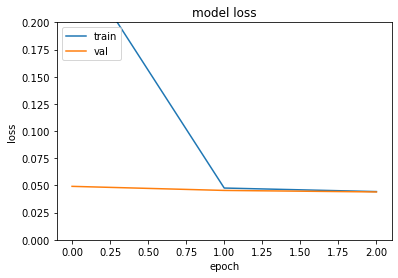

In [146]:
from matplotlib import pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(0, 0.2)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_loss(history)

### Test model

In [148]:
!pip install evaluate -q
import evaluate
import transformers.models

In [248]:
def test_model(model: transformers.models, dataset: datasets.arrow_dataset.Dataset, 
               max_length:int=20, idx_sample: Union[int, List[int]]=88) -> None:
    '''
        This function takes as input a dataset, it runs inference on the given
        model and then it prints the question, the real answer and the predicted
        one.
        Parameters:
            - model: transformers.models
                The model to run inference on.
            - dataset: datasets.arrow_dataset.Dataset
                The dataset from which the function takes the samples.
            - max_length: int
                It's the maximum length allowed during the generation.
            - idx_sample: int | list[int]
                If an integer is passed, then the function computes the answer
                for a single sample, otherwise for each sample specified in the
                list (through the index).

        Return:
            The function simply prints the results without returning anything.
    '''
    if isinstance(idx_sample, int):
        idx_sample = [idx_sample]

    # Check if indices are without dataset bounds    
    max_ind = max(idx_sample)
    if max_ind >= len(dataset):
        print(f"Error: index {max_ind} is out of bounds (dataset of length {len(dataset)}.")
        return None

    for idx in idx_sample:
        inp_test, _ = tokenize_samples(dataset[idx], tokenizer)

        greedy_output = model.generate(inp_test['input_ids'],
                                       attention_mask=inp_test['attention_mask'],
                                       max_length=max_length)# decoder_start_token_id=model.config.decoder.bos_token_id

        print(f"- The question {idx+1} is:\n\t{dataset[idx]['questions']}")
        print(f"- The actual answer is:\n\t{dataset[idx]['answers']}")
        print(f"- The predicted answer is (shitty):\n\t"
              f"{tokenizer.decode(greedy_output.numpy()[0], skip_special_tokens=True)}")


def compute_f1_score(model: transformers.models, X: dict, y: np.ndarray, metric: evaluate.Metric, 
                     num_samples: int=None, max_length: int=20) -> np.array:
    '''
        This function takes as input a dataset, it runs inference on the given
        model and then it returns the F1 score metric.
        Parameters:
            - model: transformers.models
                The model to run inference on.
            - X: dict
                The structure that contains the input_ids and attention_mask, it
                is obtained doing 'variable.data' on an object of type
                transformers.tokenization_utils_base.BatchEncoding.
            - y: np.array
                The array of the tokenized answers
            - metric: evaluate.Metric
                It's the metric object to consider for the computation.
            - num_samples: int 
                The function takes from the samples the first 'num_samples'
                samples.
            - max_length: int
                It's the maximum length used during the generation

        Return:
            The f1 score.
    '''
    # Take all the samples
    if num_samples == None:
        num_samples = len(y)

    ids, att_mask = X['input_ids'][:num_samples], X['attention_mask'][:num_samples]
    labels = y[:num_samples, :max_length]
    greedy_output = model.generate(ids, attention_mask=att_mask, max_length=max_length).numpy()
    
    for i in range(num_samples):
        # For f1 score on strings
        #pred_string = tokenizer.decode(greedy_output[i], skip_special_tokens=True)
        #ref_string = tokenizer.decode(labels[i], skip_special_tokens=True)

        pred = greedy_output[i, :max_length]

        metric.add_batch(predictions=pred, references=labels[i])

    f1_score = metric.compute(average=None)
    return f1_score

In [215]:
test_model(model, dataset_test, max_length=20, idx_sample=88)

- The question 89 is:
	Was there a storm headed that way?
- The actual answer is:
	Yes
- The predicted answer is (shitty):
	yes


### Check F1 score

In [253]:
f1_metric = evaluate.load("f1")

f1_score = compute_f1_score(model, x_test.data, y_test, f1_metric, 100)

print(f"The f1 score is {np.mean(f1_score['f1'])}")

The f1 score is 0.009151945214164002


# Assignment Evaluation

The following assignment points will be awarded for each task as follows:

* Task 1, Pre-processing $\rightarrow$ 0.5 points.
* Task 2, Dataset Splitting $\rightarrow$ 0.5 points.
* Task 3 and 4, Models Definition $\rightarrow$ 1.0 points.
* Task 5 and 6, Models Training and Evaluation $\rightarrow$ 2.0 points.
* Task 7, Analysis $\rightarrow$ 1.0 points.
* Report $\rightarrow$ 1.0 points.

**Total** = 6 points <br>

We may award an additional 0.5 points for outstanding submissions. 
 
**Speed Bonus** = 0.5 extra points <br>

# Report

We apply the rules described in Assignment 1 regarding the report.
* Write a clear and concise report following the given overleaf template (**max 2 pages**).
* Report validation and test results in a table.$^1$
* **Avoid reporting** code snippets or copy-paste terminal outputs $\rightarrow$ **Provide a clean schema** of what you want to show

# Comments and Organization

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

Structure your code for readability and maintenance. If you work with Colab, use sections. 

This allows you to build clean and modular code, as well as easy to read and to debug (notebooks can be quite tricky time to time).

# FAQ (READ THIS!)

---

**Question**: Does Task 3 also include data tokenization and conversion step?

**Answer:** Yes! These steps are usually straightforward since ```transformers``` also offers a specific tokenizer for each model.

**Example**: 

```
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
encoded_text = tokenizer(text)
%% Alternatively
inputs = tokenizer.tokenize(text, add_special_tokens=True, max_length=min(max_length, 512))
input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
```

**Suggestion**: Hugginface's documentation is full of tutorials and user-friendly APIs.

---
---

**Question**: I'm hitting **out of memory error** when training my models, do you have any suggestions?

**Answer**: Here are some common workarounds:

1. Try decreasing the mini-batch size
2. Try applying a different padding strategy (if you are applying padding): e.g. use quantiles instead of maximum sequence length

---
---

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# The End!

Questions?